## Симплекс метод

Модифицируем код из 1-ой лабораторной работы для решения матричной игры

In [68]:
import numpy as np
import fractions
np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

In [87]:
class SimplexMethod:
    @staticmethod
    def __find_col(simplex_table, *, debug=False):
        column = np.argmin(simplex_table[-1, 1:])
        column += 1
        if debug:
            print(f'column: {column}')
        return column

    @staticmethod
    def __iter(simplex_table, base, *, eps=1e-9, debug=False):
        simplex_table_old = np.copy(simplex_table)
        column = SimplexMethod.__find_col(simplex_table, debug=debug)

        with np.errstate(divide='ignore'):
            d = simplex_table[:-1, 0] / simplex_table[: -1, column]
        d[simplex_table[:-1, column] <= 0] = np.NAN

        try:
            row = np.nanargmin(d)
        except ValueError:
            raise RuntimeError('None or infinity solutions')

        base[row] = column

        if debug:
            with np.printoptions(precision=3, suppress=True):
                print(f'd: {d}')
                print(f'column: {column}, row: {row}, a_rl: {simplex_table[row, column]}')
                print(simplex_table)

        simplex_table[row, :] /= simplex_table_old[row, column]
        simplex_table[:, column] = 0
        simplex_table[row, column] = 1

        for i in range(simplex_table.shape[0]):
            for j in range(simplex_table.shape[1]):
                if i == row or j == column:
                    continue
                simplex_table[i, j] = simplex_table_old[i, j] - (simplex_table_old[row, j] * simplex_table_old[i, column]) / simplex_table_old[row, column]

        simplex_table[abs(simplex_table) < eps] = 0
        return simplex_table, base

    @staticmethod
    def create_plan(game):
        limits = game
        simplex_table = np.hstack((np.ones((limits.shape[0], 1)), limits, np.eye(limits.shape[0])))
        simplex_table = np.vstack((simplex_table, np.hstack((np.array([0]), np.ones(limits.shape[1]) * -1, np.zeros(limits.shape[0])))))
        return simplex_table

    @staticmethod
    def solve_reverse(simplex_table, base, *, debug=False):
        res_table, res_base = SimplexMethod.solve(simplex_table, base, debug=debug)

        table = simplex_table[: -1, res_base]
        D = np.linalg.inv(table)
        C = np.zeros(res_table.shape[1] - 1)
        C[res_base - 1] = 1
        C = C[ : -res_table.shape[0] + 1]
        return np.dot(C, D)



    @staticmethod
    def solve(simplex_table, base, *, debug=False):
        table = np.copy(simplex_table)
        while np.any(table[-1, 1:] < 0):
            table, base = SimplexMethod.__iter(table, base, debug=debug)

        if debug:
            print('Final table:')
            with np.printoptions(precision=3, suppress=True):
                print(table)
        return table, base

    @staticmethod
    def solve_game(game, *, debug=False):
        price_appended = 0
        if game.min() < 0:
            price_appended = abs(game.min())
            game += price_appended

        plan = SimplexMethod.create_plan(game)
        base = np.arange(plan.shape[1] - plan.shape[0] + 1, plan.shape[1])
        table, base = SimplexMethod.solve(plan, base, debug=debug)
        a1 = SimplexMethod.solve_game_A(table, base, debug=debug)
        a2 = SimplexMethod.solve_game_B(plan, base, debug=debug)
        v = 1 / table[-1, 0]
        return v - price_appended , v * a1,  v * a2

    @staticmethod
    def solve_game_A(simplex_table, base, *, debug=False):
        C = np.zeros(simplex_table.shape[1] - 1)
        C[base - 1] = simplex_table[:-1, 0] 
        C = C[ : simplex_table.shape[0] -1]
        return C

    @staticmethod
    def solve_game_B(simplex_table, base, *, debug=False):
        A = simplex_table[: -1, base]   
        D = np.linalg.inv(A)
        C = (base <= base.shape).astype(int)
        if (debug):
            print(f'C: {C}')
            print(f'D:\n{D}')
        return np.dot(C, D)


# Tasks

## Task 1

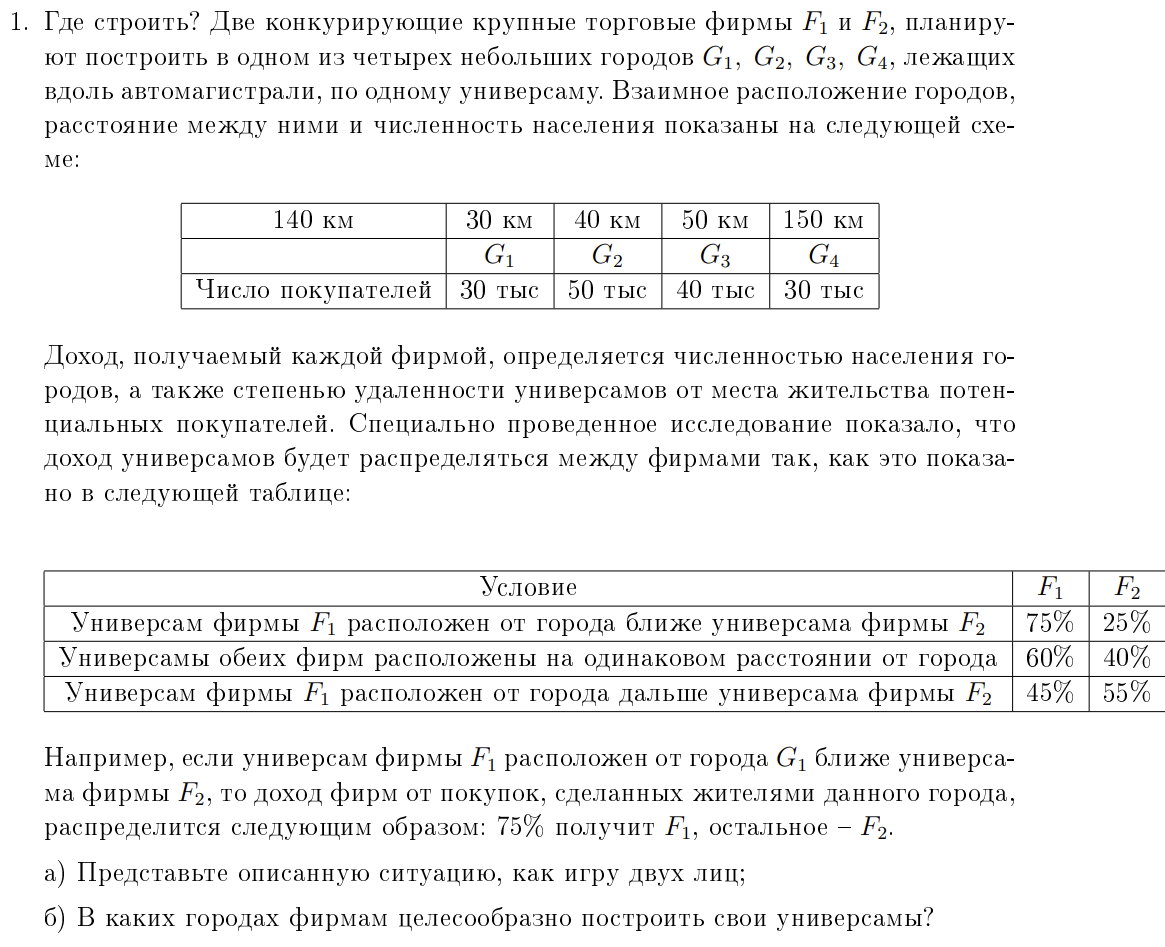

In [55]:
dist_matrix = [
    [30, 40, 50, 150],
    [30, 50, 40, 30]
]

def get_profit(f1, f2, g):
    f1_dst = sum(dist_matrix[0][f1:g]) if f1 < g else sum(dist_matrix[0][g:f1])
    f2_dst = sum(dist_matrix[0][g:f2]) if g < f2 else sum(dist_matrix[0][f2:g])
    if f1_dst > f2_dst:
        return dist_matrix[1][g] * 0.45
    elif f1_dst < f2_dst:
        return dist_matrix[1][g] * 0.75
    else:
        return dist_matrix[1][g] * 0.60

def generate_matrix():
    matrix = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            profit = sum([get_profit(i, j, g) for g in range(4)])
            matrix[i][j] = profit
    return matrix


In [62]:
matrix = generate_matrix()
matrix

array([[ 90. ,  76.5,  91.5,  91.5],
       [103.5,  90. ,  91.5, 103.5],
       [ 88.5,  88.5,  90. , 103.5],
       [ 88.5,  76.5,  76.5,  90. ]])

In [63]:
v, p1, p2 = SimplexMethod.solve_game(matrix, debug=False)
print(f'v: {v}')
print(f'p1: {p1}')
print(f'p2: {p2}')

v: 90.0
p1: [0. 1. 0. 0.]
p2: [0. 1. 0. 0.]


Цена игры: 90

Лучшая стратегия для обоих игроков: 2, 2

## Task 2

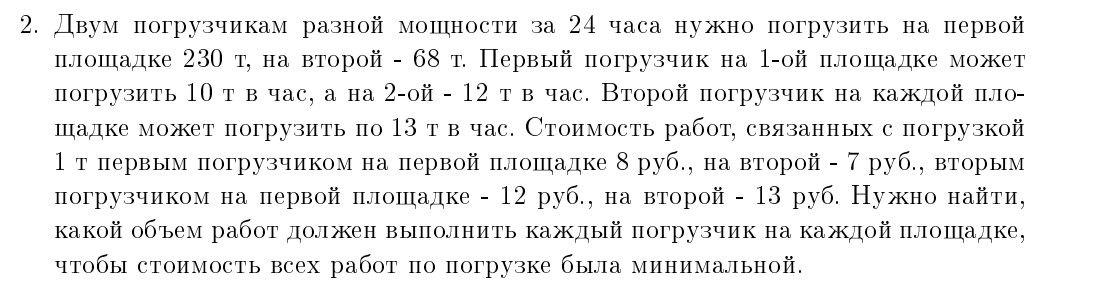

Пусть $x_1$ - колличество работы, которую выполнил 1 погрузчик на 1 площадке, а $x_2$ - на второй 

Пусть $x_3$ - колличество работы, которую выполнил 2 погрузчик на 1 площадке, а $x_4$ - на второй

Тогда $F(x) = 8x_1 + 7x_2 + 12x_3 + 13x_4 \rightarrow \min$

Ограничения:
\begin{equation}
    \begin{cases}
    x_1 + x_3 = 230\\
    x_2 + x_4 = 68\\
    \frac{x_1}{10} + \frac{x_2}{12} \leq 24\\
    \frac{x_3}{13} + \frac{x_4}{13} \leq 24\\
    \frac{x_1}{10} + \frac{x_3}{13} \leq 24\\
    \frac{x_2}{12} + \frac{x_4}{13} \leq 24\\
    \end{cases}
\end{equation}


Воспользуемся лабораторной №1(мне слишком лень переносить сюда еще и метод дополнительного базиса)

8x1+7x2+12x3+13x4

x1+x3=230

X2+x4=68

0.1x1+0.083x2<=24

0.077x3+0.077x4<=24

0.1x1+0.076x3<=24

0.083x2+0.076x4<=24

4

In [69]:
res = np.array([2.50266667e+03, 1.83333333e+02, 6.80000000e+01, 4.66666667e+01,
       0.00000000e+00])
res

array([250266667/100000, 183333333/1000000, 68, 140/3, 0])

Cледовательно: первый должен выкопать на 1-ом участке 183т, а на втором - 68т, второй же должен работать только на 1-ом участке и выкопать всего 47т. стоить же это будет 2504р

## Task 4

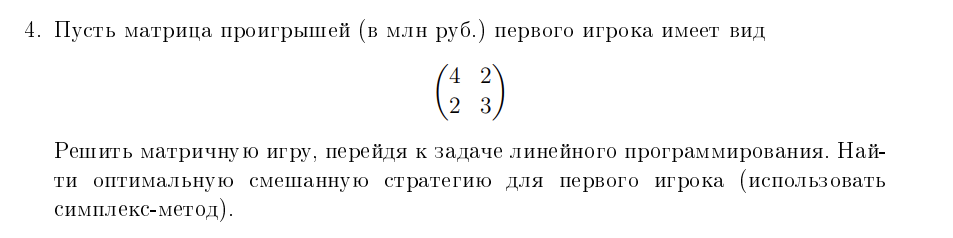

In [70]:
matrix = np.array([[4, 2], [2, 3]])
matrix

array([[4, 2],
       [2, 3]])

У нас есть 2 варианта решения подобных задач: домножить матрицу на -1, чтобы получить матрицу выигрышей первого игрока или же транспонировать матрицу и получить матрицу выигрышей второго игрока. В данном случае мы решили воспользоваться вторым вариантом.

In [71]:
matrix = matrix.T

In [73]:
SimplexMethod.solve_game(matrix, debug=True)

column: 1
d: [0.25 0.5 ]
column: 1, row: 0, a_rl: 4.0
[[ 1.  4.  2.  1.  0.]
 [ 1.  2.  3.  0.  1.]
 [ 0. -1. -1.  0.  0.]]
column: 2
d: [0.5  0.25]
column: 2, row: 1, a_rl: 2.0
[[ 0.25  1.    0.5   0.25  0.  ]
 [ 0.5   0.    2.   -0.5   1.  ]
 [ 0.25  0.   -0.5   0.25  0.  ]]
Final table:
[[ 0.125  1.     0.     0.375 -0.25 ]
 [ 0.25   0.     1.    -0.25   0.5  ]
 [ 0.375  0.     0.     0.125  0.25 ]]
C: [1 1]
D:
[[3/8 -1/4]
 [-1/4 1/2]]


(2.6666666666666665, array([1/3, 2/3]), array([1/3, 2/3]))

fractions не смог.. $v = 8/3$

Цена игры  -8/3

Оптимальная стратегия игрока 1: 1/3, 2/3

Оптимальная стратегия игрока 2: 1/3, 2/3

## Task 5

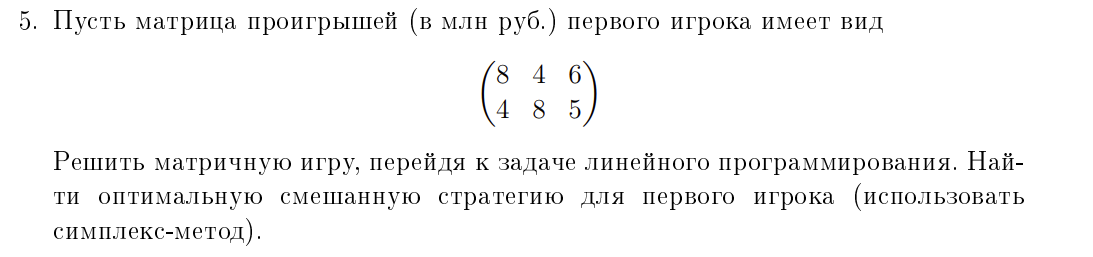

In [81]:
matrix = np.array([[8, 4, 6], [4, 8, 5]])
matrix

array([[8, 4, 6],
       [4, 8, 5]])

In [82]:
matrix = matrix.T
matrix

array([[8, 4],
       [4, 8],
       [6, 5]])

In [88]:
SimplexMethod.solve_game(matrix, debug=False)

(6.0, array([1/2, 1/2, 0]), array([1/2, 1/2, 0]))

Цена игры: -6

Стратегия игрока 1: 1/2, 1/2

Стратегия игрока 2: 1/2, 1/2, 0

## Task 6

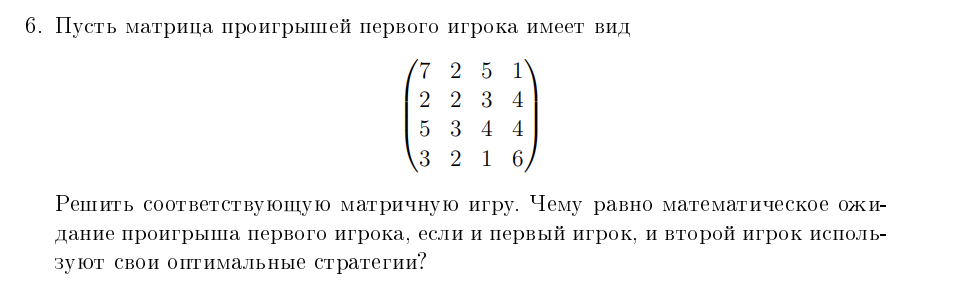

In [89]:
matrix = np.array([[7, 2, 5, 1], [2, 2, 3, 4], [5, 3, 4, 4], [3, 2, 1, 6]])
matrix

array([[7, 2, 5, 1],
       [2, 2, 3, 4],
       [5, 3, 4, 4],
       [3, 2, 1, 6]])

In [92]:
matrix = matrix.T
matrix

array([[7, 2, 5, 1],
       [2, 2, 3, 4],
       [5, 3, 4, 4],
       [3, 2, 1, 6]])

In [94]:
SimplexMethod.solve_game(matrix)

(3.0, array([0, 1, 0, 0]), array([0, 0, 1, 0]))

Цена игры: -3

Стратегия игрока 1: 0, 0, 1, 0


Стратегия игрока 2: 0, 1, 0, 0

# Task 7

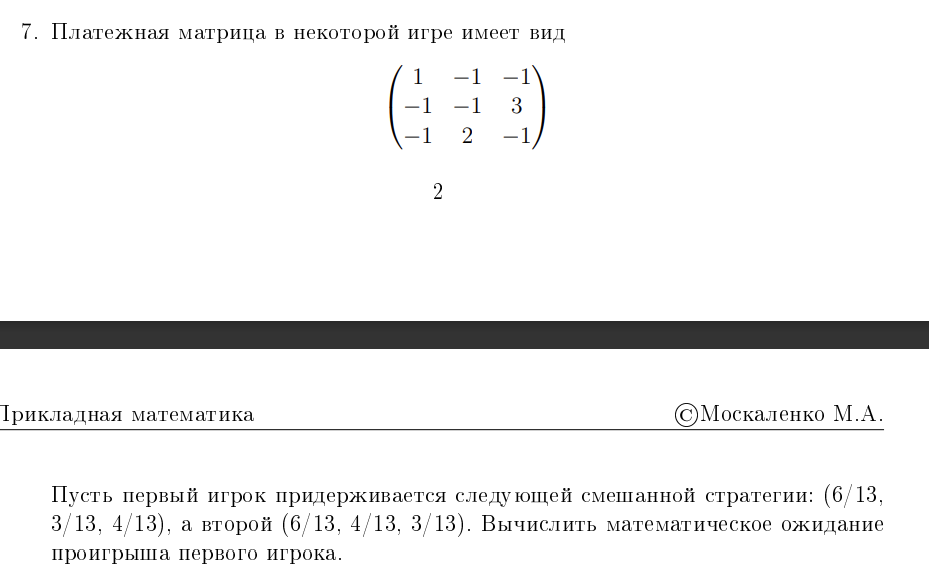

In [95]:
matrix = np.array([[1, -1, -1], [-1, -1, 3], [-1, 2, -1]])

In [96]:
matrix

array([[1, -1, -1],
       [-1, -1, 3],
       [-1, 2, -1]])

In [97]:
SimplexMethod.solve_game(matrix, debug=False)

(-0.07692307692307687, array([6/13, 4/13, 3/13]), array([6/13, 3/13, 4/13]))

И снова fractions не смог, $v = -1/13$

Так как данная нам в условии смешанная стратегия является оптимальной, то и мат ожидание проигрыша первого игрока будет равна $-v = 1/13$

## Task 8

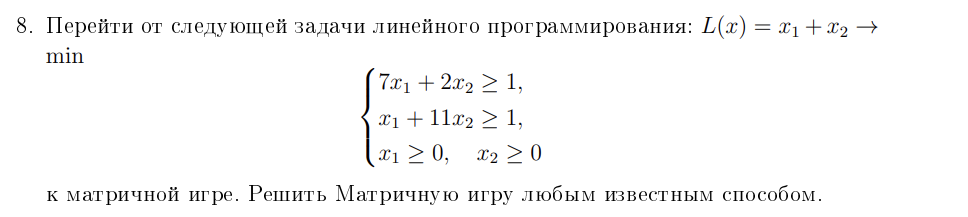

In [98]:
matrix = np.array([[7, 2], [1, 11]]).T
matrix

array([[7, 1],
       [2, 11]])

In [99]:
SimplexMethod.solve_game(matrix)

(5.0, array([2/3, 1/3]), array([3/5, 2/5]))

Цена игры: 5.0

Стратегия игрока 1: 2/3, 1/3

Стратегия игрока 2: 3/5, 2/5

## Task 9

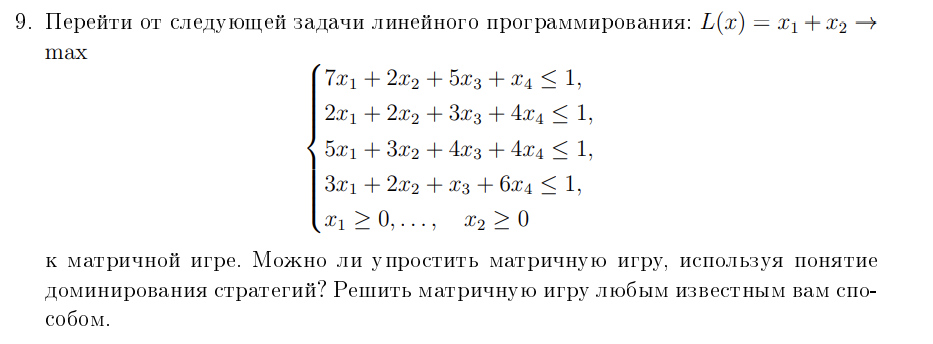

In [100]:
matrix = np.array([[7, 2, 5 , 1], [2, 2, 3, 4], [5, 3, 4, 4], [3, 2, 1, 6]])
matrix

array([[7, 2, 5, 1],
       [2, 2, 3, 4],
       [5, 3, 4, 4],
       [3, 2, 1, 6]])

Упростим матрицу с помощью доминирующих стратеший

In [101]:
matrix = np.array([[2, 5, 1], [3, 4, 4], [2, 1, 6]])
matrix

array([[2, 5, 1],
       [3, 4, 4],
       [2, 1, 6]])

In [102]:
SimplexMethod.solve_game(matrix, debug=False)

(3.0, array([1, 0, 0]), array([0, 1, 0]))

Цена игры: 3

стратегия игрока 1: 1, 0, 0

стратегия игрока 2: 0, 1, 0